# Transfer Learning with Pytorch

In this excercise, you will implement a 2-class classification neural network, using transfer learning from a pre-trained resnet18 network. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve (but not identical). The pre-trained network could have been trained on a different dataset and sometimes also on a different task. The important thing is that it would be a related task and a realted dataset. This way, we can leverage previous learneinng to solve the new problem (instead of training the model from scratch). The ResNet18 model was pre-trained on the [ImageNet](http://image-net.org/index) dataset (a large dataset consisting of 1.4M images and 1000 classes). 

Transfer learning can be used in two ways:
1. Feature extractor: Here we remove top layers, freeze the weights of all remaining layers, add a new fully connected layers on top of the pretrained model. Then. we train only these new layers to solve the new task.
2. Fine tuning: Here we unfreezing the entire model (or part of it), add a new fully connected layers on top of the pre-trained model (as before) and re-train the entire model on the new data with a very low learning rate. We can use either end-to-end re-training, or re-train only part of the network.

### CIFAR-10 Dataset:

In this assignment, you will need to perform transfer learning using the ResNet18 network in order to classify and discern between images of cats and dogs in a different dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 



# Part 1- Feature Extractor

In this part of the exercise, you need to classify images of 'Cat' and 'Dog' by using transfer learning with the feature extractor approach and a pre-trained ResNet18 network.

The pre-trained model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers. You will need to extract the image representation that should be fed into a classifier. For the classifier, please use a single fully-connected layer. 


In order to make things efficient, start by using the ResNet18 network in order to extract image represetnations for the images in CIFAR-10 dataset. Please make sure to this only once (please do not extract the image representations each time it is needed in the training phase)! You can store the resulting image representations as feature vectors and train the classifier using these vectors. At test time, you can merge both network in order to achive a single end-to-end classifier.  
Note: This is different from what you saw in the recitation (dl_r4_cnns).

At the test time, you can merge the feature extraction netowork with the new prediction head, in order to recive a "full solution".


**Let's first import all the packages that you will need during this part of assignment:**

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import time
import tqdm
from tqdm import tqdm
import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc,accuracy_score
from torch.utils.data import DataLoader, Dataset
import os

The ResNet18 network requires images of at least 200x200 pixels. However, the CIFAR-10 dataset consists of small images of 32x32 pixels. Hence, you will need to reshape the images before we use them into the ResNet18 network.
Additionally, you will need to match the normalization used while training the ResNet18: each color channel should be normalized separately. The channel means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

**Use the transforms library from  torchvision and definethese transformations:**

In [2]:
# Specify transforms using torchvision.transforms as transforms library

#transformation for the training data - here we will take 224 pixels every time from different part of the picture for generalization
train_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [
            0.229, 0.224, 0.225]),
    ]
)
#transformation for the validation data - here we take always the center of the image to get better results
infer_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [
            0.229, 0.224, 0.225]),
    ]
)


#### Load CIFAR10 dataset and transform dataset from torchvision:

In [3]:

# a class that was made to take only the 'cat' and 'dog' labels from ciphar dataset


class SubLoader(torchvision.datasets.CIFAR10):
    def __init__(self, exclude_list, *args, **kwargs):
        super(SubLoader, self).__init__(*args, **kwargs)

        if exclude_list == []:
            return
        labels = np.array(self.targets)
        exclude = np.array(exclude_list).reshape(1, -1)
        mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)
        self.data = self.data[mask]
        self.targets = labels[mask].tolist()
        self.targets = list(map(lambda x: 1 if x == 5 else 0, self.targets))


# a class that inherit from Dataset and overide __len__ and __getitem__
# overrides __len__ in order to limit the number of rows returned to a given parameter len_limit as we asked
# overrides __getitem__ to return equal number of rows for each label as we asked(equal number of dogs and cats)
class CIFAR10_DataLoader_Len_Limited(Dataset):
    def __init__(self, original_datset, len_limit=None):
        self.len_limit = len_limit
        self.original_datset = original_datset
        self.label_to_indices = {label: np.where(np.array(self.original_datset.targets) == label)[0].tolist()for label in [0, 1]}
        self.ind_0 = 0  # counter for label 0
        self.ind_1 = 0  # couner for label 1

    def __getitem__(self, ind):
        # In case we have already return more label 1 rows than label 0 rows, so the next row will be taken
        # from the minority class
        if(self.ind_0 <= self.ind_1):
            next_ind = self.label_to_indices[0][self.ind_0]
            label = self.original_datset.targets[next_ind]
            self.ind_0 += 1
            if(ind == self.len_limit-1):
                self.ind_0 = 0
                self.ind_1 = 0
            return self.original_datset[next_ind]
        else:
            next_ind = self.label_to_indices[1][self.ind_1]
            label = self.original_datset.targets[next_ind]
            self.ind_1 += 1
            if(ind == self.len_limit-1):
                self.ind_0 = 0
                self.ind_1 = 0
            return self.original_datset[next_ind]

    def __len__(self):  # return at most len_limit rows from the dataset
        # we were asked to limit the number of training examples to do the training process more efficient
        if self.len_limit:
            return min(len(self.original_datset), self.len_limit)
        return len(self.original_datset)






In [4]:
# arguments for Net and dataloaders
class NetArgs:
    lr = 1e-4
    lr_finetune = 1e-5
    weight_decay = 5e-6
    num_epochs = 5000
    early_stopping_min_improvement = 1e-7
    early_stopping_num_epochs = 5
    early_stopping_min_improvement_ft = 1e-2
    early_stopping_num_epochs_ft = 2
    batch_size = 150
    train_size = 2*800
    test_size = 2*250
    X_train_extracted_from_resnet18_file_name = "X_extracted_features_train18.pt"
    y_train_extracted_from_resnet18_file_name = "y_extracted_features_train18.pt"
    X_test_extracted_from_resnet18_file_name = "X_extracted_features_test18.pt"
    y_test_extracted_from_resnet18_file_name = "y_extracted_features_test18.pt"
    X_train_extracted_from_resnet34_file_name = "X_extracted_features_train34.pt"
    y_train_extracted_from_resnet34_file_name = "y_extracted_features_train34.pt"
    X_test_extracted_from_resnet34_file_name = "X_extracted_features_test34.pt"
    y_test_extracted_from_resnet34_file_name = "y_extracted_features_test34.pt"

args = NetArgs()

In [5]:
# Note: In order to separating the data/label you can apply "classes"/"targets" methods on CIFAR10 data sets

#flag that checkes if loading again and extract resnet18 features is needed or we should use extracted features files(used during development)
RESNET18_EXTRACTED_DATA_EXIST = (os.path.exists(args.X_train_extracted_from_resnet18_file_name) == True and
                                     os.path.exists(args.y_train_extracted_from_resnet18_file_name) == True and
                                     os.path.exists(args.X_test_extracted_from_resnet18_file_name) == True and
                                     os.path.exists(args.y_test_extracted_from_resnet18_file_name) == True)
#flag that checkes if loading again and extract resnet34 features is needed or we should use extracted features files
RESNET34_EXTRACTED_DATA_EXIST = (os.path.exists(args.X_train_extracted_from_resnet34_file_name) == True and
                                     os.path.exists(args.y_train_extracted_from_resnet34_file_name) == True and
                                     os.path.exists(args.X_test_extracted_from_resnet34_file_name) == True and
                                     os.path.exists(args.y_test_extracted_from_resnet34_file_name) == True)

# classes of the ciphar-10
labels = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
          'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
print(labels)
#exclude all classes except dog and cat
exclude_labels = labels
del exclude_labels['dog']
del exclude_labels['cat']
exclude_labels = list(exclude_labels.values())

# Subloader inherits from Dataloader and overrides __init__. It takes only the 'dog' and 'cat' examples from the dataset
tr_dataset = SubLoader(exclude_labels, "cifar",
                        transform=train_transform, train=True, download=True)
# CIFAR10_DataLoader_Len_Limited is a class inherits from cifar10DataSet and limits and number of examples used from the dataset to len_limit
tr_dataloader = DataLoader(
    CIFAR10_DataLoader_Len_Limited(tr_dataset, int(args.train_size)), batch_size=args.batch_size
)
#create validation dataloader
val_dataset = SubLoader(exclude_labels, "cifar",
                        transform=infer_transform, train=False, download=False)
val_dataloader = DataLoader(
    CIFAR10_DataLoader_Len_Limited(val_dataset, int(args.test_size)), batch_size=int(args.test_size)
)


{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


Extracting cifar/cifar-10-python.tar.gz to cifar


**Note that the CIFAR10 data set includes 10 labels. Please extract from the entire dataset, only the images with 'Cat' or 'Dog' labels.
In order to make the training process faster, you will need to trim the train set to 800 training images of each label (800 dogs and 800 cats). The test set should be trimmed to 250 images of cats and 250 images of dogs.**

**Download the ResNet18 Network from torchvision.models (as seen in the tutorial):**

In [6]:
import matplotlib.pyplot as plt

class MyResNet(nn.Module):
#A class inherits from nn and gets 2 parameter classifyer that replaces resnet head and which version 
#of resnet we should load resnet18 or resnet34
    def __init__(self, classifyer, res34or18):
        super(MyResNet, self).__init__()
        if(res34or18 == 18):
            resnet = models.resnet18(pretrained=True)
        else:
            resnet = models.resnet34(pretrained=True)
        num_ftrs = resnet.fc.in_features
        #cut resnet head
        resnet.fc = nn.Identity()
        #save features extractor as self.features
        self.features = resnet
        # Freezing resnet params:
        for param in self.features.parameters():
            param.requires_grad = False
        # fc layer with softMax for classifying(given as parameter)
        self.classifyer = classifyer
    # function that feed forward images in resnet and returns tensor of extracted features
    def extract_features_from_dataloader(self, dataloader):
        X_extracted_features = torch.empty([0, 512])
        y_extracted_features = torch.empty([0]).long()
        self.features.eval()
        with torch.no_grad():
            for X, y in dataloader:
                extracted_batch_features = self.features(X)
                X_extracted_features = torch.cat(
                    [X_extracted_features, extracted_batch_features], dim=0)
                y_extracted_features = torch.cat(
                    [y_extracted_features, y], dim=0)

        return X_extracted_features, y_extracted_features

    def forward(self, X):
      # In case we get extracted features tensor (The length of it's shape is 2)
        if(len(X.shape) != 4):
            return self.classifyer(X)
        # The (The length of image shape is 4)
        #in case we feed forward images with shape [n,C,H,W] the len of shape is 4 so we need only to extract features
        # using self.features and then feed it to the classifyer to get the output probabilities
        else:
            X = self.features(X)
            return self.classifyer(X)





#### Now, use the pre-trained Resnet18 to extract feautres from the CIFAR10 dataset and feed your classifier with these feature vectors. To do that, you need to cut the head of the pre-trained ResNet18 model, then feed the model with the CIFAR10 data sets (train and test).  The resulting image representations should be "flattened" and used as feature vectors:

In [7]:
classifyer = nn.Sequential(nn.Linear(512, 2)) # classifyer is one linear layer(softmax layer from CrossEntropyLoss)
net = MyResNet(classifyer, 18) #resnet18  with classifyer instead of resnet.fc
# in case we already extracted the features using resnet18, skip the extraction process and load it from the files(for development mode)
if(RESNET18_EXTRACTED_DATA_EXIST == False):
  #extract training features tensor with shape  of [800*2,512]
    X_extracted_features_train, y_extracted_features_train = net.extract_features_from_dataloader(
        tr_dataloader)
  #extract validation features tensor with shape  of [250*2,512]
    X_extracted_features_test, y_extracted_features_test = net.extract_features_from_dataloader(
        val_dataloader)
    print(X_extracted_features_train.shape)
    print(X_extracted_features_test.shape)
    # save the extracted features to files(for development mode)
    torch.save(X_extracted_features_train,
                args.X_train_extracted_from_resnet18_file_name)
    torch.save(y_extracted_features_train,
                args.y_train_extracted_from_resnet18_file_name)
    torch.save(X_extracted_features_test,
                args.X_test_extracted_from_resnet18_file_name)
    torch.save(y_extracted_features_test,
                args.y_test_extracted_from_resnet18_file_name)
else:
    # load the extracted features files(for development mode)
    X_extracted_features_train = torch.load(
        args.X_train_extracted_from_resnet18_file_name)
    y_extracted_features_train = torch.load(
        args.y_train_extracted_from_resnet18_file_name)
    X_extracted_features_test = torch.load(
        args.X_test_extracted_from_resnet18_file_name)
    y_extracted_features_test = torch.load(
        args.y_test_extracted_from_resnet18_file_name)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



torch.Size([1600, 512])
torch.Size([500, 512])


# Logistic Regression with scikit-learn library:

#### Here, you need to use a logistic regession model from scikit-learn and train it with the data you prepared above. You need to calculate and report the accuracy and AUC for the train and test sets and explain your results.

In [8]:

# logistic regression with sklearn

logisticRegr = LogisticRegression(penalty='l2',solver='lbfgs',tol=1e-3, max_iter=1000)
clf = logisticRegr.fit(X_extracted_features_train.numpy(),
                        y_extracted_features_train.numpy())
pred_probs_train_lr = clf.predict_proba(X_extracted_features_train)[:,1] # prediction on training set
pred_probs_test_lr = clf.predict_proba(X_extracted_features_test)[:,1]  #prediction on test set


# train accuracy and auc
accuracy_train_lr = clf.score(
    X_extracted_features_train, y_extracted_features_train)
auc_train_lr = roc_auc_score(y_extracted_features_train.numpy(),pred_probs_train_lr)
# test accuracy and auc
accuracy_test_lr = clf.score(
    X_extracted_features_test, y_extracted_features_test)
auc_test_lr = roc_auc_score(y_extracted_features_test.numpy(),pred_probs_test_lr)

print("train results:")
print('accuracy:', accuracy_train_lr)
print('auc', auc_train_lr)
print("test results:")
print('accuracy:', accuracy_test_lr)
print('auc', auc_test_lr)





train results:
accuracy: 0.983125
auc 0.9983390625
test results:
accuracy: 0.81
auc 0.910512


We used Logisitic regression algorithm to classify the images. First we used Resnet to extract the features into 1 dimensional vector, then we could have use any supevised learning algorithm(SVM,Random Forest, Logistic regression,...) to make the classification on the 1 dimensional vectors.
We used logistic regression to get probablistic result and as we can see the training error is very small (auc and accuracy close to 1) while the accuracy on the test set is 0.83(overfitted even we used L2 regularization)

# Logistic Regression with pytorch:

#### Next, you need to use a logistic regession using pythourch as follows:


1. Explain the choice of architecture in the head of the neural network.
2. Plot training loss per epoch.
3. Plot AUC per epoch for train and validation sets.
4. Explain your results and findings.
5. Does adding one or two hidden layers affect the generalization capabilities of the model?

#### Define the model:

In [9]:
#Define above in MyResNet class

We used this head: Linear(in_features=512, out_features=2, bias=True) because the last layer of resnet18 and resnet 34 returns a tensor with shape [n,512] .  out_features=2 because we classify into 2 classes dogs and cats(we could have use also out_features=1 with BCELoss but we wanted to try to use CrossEntropyLoss  (even it's the same for the binary case).CrossEntropyLoss executes Softmax on the output before calculating loss.

#### Training and validation:

Training Loop, Infer and graphs functions

In [10]:

# can pass to function dataloader or X,y
def infer(net, criterion, X=None, y=None, dataloader=None):
    net.eval()
    running_loss = 0
    running_auc = 0
    running_acc=0
    num_of_rows = 0
    #train_on_gpu2 = torch.cuda.is_available()
    with torch.no_grad():
        # case when gets X and y tensors
        if(dataloader == None):
            pred = net(X)
            loss = criterion(pred, y).item()
            output_for_auc = torch.sigmoid(pred).detach().numpy()[:, 1]
            auc = roc_auc_score(y, output_for_auc)
            return loss, auc
        # case when gets dataloader
        else:
            for X_batch, y_batch in dataloader:
                #if train_on_gpu2:
                #    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                pred = net(X_batch)
                loss = criterion(pred, y_batch).item()
                output_for_auc = torch.sigmoid(pred).detach().numpy()[:, 1]
                auc = roc_auc_score(y_batch, output_for_auc)
                _, predicted = torch.max(pred.data, 1)
                predicted=predicted.detach().numpy()
                accuracy=accuracy_score(y_batch,predicted)
                running_loss += loss*y_batch.shape[0]
                running_auc += auc*y_batch.shape[0]
                running_acc+=accuracy*y_batch.shape[0]
                num_of_rows += y_batch.shape[0]
            return running_loss / num_of_rows, running_auc / num_of_rows,running_acc/num_of_rows

# training loop function
# gets: net,arguments of the net, train and validation data, Loss function and optimizer
def training_loop(
    args,
    net,
    X_train,
    y_train,
    X_test,
    y_test,
    tr_dataloader=None,
    val_dataloader=None,
    criterion_func=nn.CrossEntropyLoss,
    optimizer_func=optim.SGD,
):
    criterion = criterion_func()
    optimizer = optim.Adam(net.parameters(), lr=args.lr,
                           weight_decay=args.weight_decay)
    tr_loss, val_loss = [None] * args.num_epochs, [None] * args.num_epochs
    tr_auc, val_auc = [None] * args.num_epochs, [None] * args.num_epochs
    test_loss, untrained_test_loss = None, None
    test_auc, untrained_test_auc = None, None
    # calculate error before training on testset
    auc_and_loss = infer(
        net,  criterion, X=X_test, y=y_test, dataloader=val_dataloader)
    untrained_test_loss = auc_and_loss[0]
    untrained_test_auc = auc_and_loss[1]
    for epoch in range(args.num_epochs):
        net.train()
        running_tr_loss = 0
        running_tr_auc = 0

        data_size = len(X_train) # get tesnor length(how many rows)
        if(data_size % args.batch_size == 0):
            no_of_batches = data_size // args.batch_size #calculate numbeer of batches
        else:
            no_of_batches = (data_size // args.batch_size)+1
        for i in tqdm(range(no_of_batches)):
            #build the next batch
            start = i*args.batch_size
            end = i*args.batch_size + args.batch_size
            x = X_train[start:end]
            y = y_train[start:end]
            optimizer.zero_grad()
            #calculate prediction using current net
            pred = net(x)
            #calculate auc and then loss with crossEntropyLoss
            output_for_auc = torch.sigmoid(pred).detach().numpy()[:, 1]
            auc = roc_auc_score(y, output_for_auc)
            loss = criterion(pred, y)
            # update weights using backpropgation
            loss.backward()
            optimizer.step()
            #update train_loss and auc_train for current iter
            running_tr_loss += loss*x.shape[0]
            running_tr_auc += auc*x.shape[0]

        #calculate train and validation losses and auc at the end of iteration
        tr_loss[epoch] = running_tr_loss.item() / data_size
        tr_auc[epoch] = running_tr_auc.item() / data_size

        auc_and_loss = infer(
            net, criterion, X=X_test, y=y_test, dataloader=None)
        val_loss[epoch] = auc_and_loss[0]
        val_auc[epoch] = auc_and_loss[1]
        print(
            f"Train loss: {tr_loss[epoch]:.2e}, Val loss: {val_loss[epoch]:.2e}")
        print(
            f"Best val loss is: {min(x for x in val_loss if x is not None):.2e}")
        #early stopping - stop if improvment in validation set is not greater than args.early_stopping_min_improvement in the last args.early_stopping_num_epochs
        if epoch >= args.early_stopping_num_epochs:
            improvement = (
                val_loss[epoch - args.early_stopping_num_epochs] -
                val_loss[epoch]
            )
            if improvement < args.early_stopping_min_improvement:
                break
    auc_and_loss = infer(net, criterion, X=X_test, y=y_test, dataloader=None)
    test_loss = auc_and_loss[0]
    test_auc = auc_and_loss[1]
    print(f"Stopped training after {epoch+1}/{args.num_epochs} epochs.")
    print(
        f"The loss is {untrained_test_loss:.2e} before training and {test_loss:.2e} after training."
    )
    print(
        f"The training and validation losses are "
        f"\n\t{tr_loss}, \n\t{val_loss}, \n\tover the training epochs, respectively."
    )
    return tr_loss, val_loss, test_loss, tr_auc, val_auc, untrained_test_loss, untrained_test_auc

# Almost the same as trainig loop but using dataloaders, only used for finetuning part
def training_loop_with_dataloaders(
    args,
    net,
    tr_dataloader=None,
    val_dataloader=None,
    criterion_func=nn.CrossEntropyLoss,
    optimizer_func=optim.SGD,
    fine_tune=False
):
    num_of_params = 0
    for par in net.features.parameters():
        num_of_params += 1
    criterion = criterion_func()
    optimizer = optim.Adam(net.parameters(), lr=args.lr,
                           weight_decay=args.weight_decay)
    tr_loss, val_loss = [None] * args.num_epochs, [None] * args.num_epochs
    tr_auc, val_auc = [None] * args.num_epochs, [None] * args.num_epochs
    tr_acc,val_acc=[None] * args.num_epochs, [None] * args.num_epochs
    test_loss, untrained_test_loss = None, None
    test_auc, untrained_test_auc = None, None
    # Note that I moved the inferences to a function because it was too much code duplication to read.
    # calculate error before training
    auc_and_loss = infer(
        net,  criterion, X=None, y=None, dataloader=val_dataloader)
    untrained_test_loss = auc_and_loss[0]
    untrained_test_auc = auc_and_loss[1]
    untrained_test_acc=auc_and_loss[2]
    print('untrained accuracy:',untrained_test_acc)
    for epoch in range(args.num_epochs):
        net.eval()
        running_tr_loss = 0
        running_tr_auc = 0
        running_tr_acc=0
        for x, y in tr_dataloader:
            optimizer.zero_grad()
            pred = net(x)
            output_for_auc = torch.sigmoid(pred).detach().numpy()[:, 1]
            auc = roc_auc_score(y, output_for_auc)
            loss = criterion(pred, y)
            _, predicted = torch.max(pred.data, 1)
            predicted=predicted.detach().numpy()
            accuracy=accuracy_score(y,predicted)
            loss.backward()
            optimizer.step()
            running_tr_loss += loss*x.shape[0]
            running_tr_auc += auc*x.shape[0]
            running_tr_acc += accuracy*x.shape[0]

        tr_loss[epoch] = running_tr_loss.item() / args.train_size
        tr_auc[epoch] = running_tr_auc.item() / args.train_size
        tr_acc[epoch] = running_tr_acc.item() / args.train_size
        auc_and_loss = infer(
            net, criterion, X=None, y=None, dataloader=val_dataloader)
        val_loss[epoch] = auc_and_loss[0]
        val_auc[epoch] = auc_and_loss[1]
        val_acc[epoch]=auc_and_loss[2]
        print('validtaion_acc:',val_acc[epoch])
        print(
            f"Train loss: {tr_loss[epoch]:.2e}, Val loss: {val_loss[epoch]:.2e}")
        print(
            f"Best val loss is: {min(x for x in val_loss if x is not None):.2e}")
        if epoch >= args.early_stopping_num_epochs:
            improvement = (
                val_loss[epoch - args.early_stopping_num_epochs] -
                val_loss[epoch]
            )
            if improvement < args.early_stopping_min_improvement:
                break
        
    auc_and_loss = infer(net, criterion, X=None, y=None,
                         dataloader=val_dataloader)
    test_loss = auc_and_loss[0]
    test_auc = auc_and_loss[1]
    print(f"Stopped training after {epoch+1}/{args.num_epochs} epochs.")
    print(
        f"The loss is {untrained_test_loss:.2e} before training and {test_loss:.2e} after training."
    )
    print(
        f"The training and validation losses are "
        f"\n\t{tr_loss}, \n\t{val_loss}, \n\tover the training epochs, respectively."
    )
    return tr_loss, val_loss, test_loss, tr_auc, val_auc, untrained_test_loss, untrained_test_auc,tr_acc,val_acc

# plot loss grpah
def plot_loss_graph(train_loss_list, validation_loss_list):
    plt.plot(train_loss_list, 'g', label='Training loss')
    plt.plot(validation_loss_list, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#plot auc graph
def plot_auc_graph(auc_train_list, auc_val_list):
    plt.plot(auc_train_list, 'g', label='Training AUC')
    plt.plot(auc_val_list, 'b', label='validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()


#plot auc graph
def plot_Accuracy_graph(acc_train_list, acc_val_list):
    plt.plot(acc_train_list, 'g', label='Training Accuracy')
    plt.plot(acc_val_list, 'b', label='validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#plot roc curve graph
def plot_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve on test set')
    plt.legend(loc="lower right")
    plt.show()



In [11]:
 # train the model using pytorch logistic regression  on resnet18 extracted features data
 tr_loss, val_loss, test_loss, tr_auc, val_auc, untrained_test_loss, untrained_test_auc = training_loop(
      args,
      net,
      X_extracted_features_train,
      y_extracted_features_train,
      X_extracted_features_test,
      y_extracted_features_test,
      val_dataloader=None,
      criterion_func=nn.CrossEntropyLoss
  )

  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 8.41e-01, Val loss: 8.03e-01
Best val loss is: 8.03e-01
Train loss: 7.92e-01, Val loss: 7.81e-01
Best val loss is: 7.81e-01
Train loss: 7.66e-01, Val loss: 7.50e-01
Best val loss is: 7.50e-01
Train loss: 7.38e-01, Val loss: 7.23e-01
Best val loss is: 7.23e-01
Train loss: 7.13e-01, Val loss: 6.98e-01
Best val loss is: 6.98e-01
Train loss: 6.88e-01, Val loss: 6.75e-01
Best val loss is: 6.75e-01
Train loss: 6.66e-01, Val loss: 6.53e-01
Best val loss is: 6.53e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 6.45e-01, Val loss: 6.34e-01
Best val loss is: 6.34e-01
Train loss: 6.26e-01, Val loss: 6.16e-01
Best val loss is: 6.16e-01
Train loss: 6.08e-01, Val loss: 5.99e-01
Best val loss is: 5.99e-01
Train loss: 5.92e-01, Val loss: 5.84e-01
Best val loss is: 5.84e-01
Train loss: 5.77e-01, Val loss: 5.70e-01
Best val loss is: 5.70e-01
Train loss: 5.63e-01, Val loss: 5.57e-01
Best val loss is: 5.57e-01
Train loss: 5.50e-01, Val loss: 5.46e-01
Best val loss is: 5.46e-01
Train loss: 5.38e-01, Val loss: 5.35e-01
Best val loss is: 5.35e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 5.27e-01, Val loss: 5.25e-01
Best val loss is: 5.25e-01
Train loss: 5.17e-01, Val loss: 5.16e-01
Best val loss is: 5.16e-01
Train loss: 5.07e-01, Val loss: 5.08e-01
Best val loss is: 5.08e-01
Train loss: 4.98e-01, Val loss: 5.00e-01
Best val loss is: 5.00e-01
Train loss: 4.90e-01, Val loss: 4.93e-01
Best val loss is: 4.93e-01
Train loss: 4.82e-01, Val loss: 4.86e-01
Best val loss is: 4.86e-01
Train loss: 4.75e-01, Val loss: 4.80e-01
Best val loss is: 4.80e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 4.68e-01, Val loss: 4.74e-01
Best val loss is: 4.74e-01
Train loss: 4.61e-01, Val loss: 4.69e-01
Best val loss is: 4.69e-01
Train loss: 4.55e-01, Val loss: 4.64e-01
Best val loss is: 4.64e-01
Train loss: 4.49e-01, Val loss: 4.59e-01
Best val loss is: 4.59e-01
Train loss: 4.43e-01, Val loss: 4.54e-01
Best val loss is: 4.54e-01
Train loss: 4.38e-01, Val loss: 4.50e-01
Best val loss is: 4.50e-01
Train loss: 4.33e-01, Val loss: 4.46e-01
Best val loss is: 4.46e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 4.28e-01, Val loss: 4.42e-01
Best val loss is: 4.42e-01
Train loss: 4.24e-01, Val loss: 4.38e-01
Best val loss is: 4.38e-01
Train loss: 4.19e-01, Val loss: 4.35e-01
Best val loss is: 4.35e-01
Train loss: 4.15e-01, Val loss: 4.32e-01
Best val loss is: 4.32e-01
Train loss: 4.11e-01, Val loss: 4.29e-01
Best val loss is: 4.29e-01
Train loss: 4.07e-01, Val loss: 4.26e-01
Best val loss is: 4.26e-01
Train loss: 4.04e-01, Val loss: 4.23e-01
Best val loss is: 4.23e-01
Train loss: 4.00e-01, Val loss: 4.20e-01
Best val loss is: 4.20e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.97e-01, Val loss: 4.18e-01
Best val loss is: 4.18e-01
Train loss: 3.93e-01, Val loss: 4.15e-01
Best val loss is: 4.15e-01
Train loss: 3.90e-01, Val loss: 4.13e-01
Best val loss is: 4.13e-01
Train loss: 3.87e-01, Val loss: 4.10e-01
Best val loss is: 4.10e-01
Train loss: 3.84e-01, Val loss: 4.08e-01
Best val loss is: 4.08e-01
Train loss: 3.81e-01, Val loss: 4.06e-01
Best val loss is: 4.06e-01
Train loss: 3.78e-01, Val loss: 4.04e-01
Best val loss is: 4.04e-01
Train loss: 3.76e-01, Val loss: 4.02e-01
Best val loss is: 4.02e-01


100%|██████████| 11/11 [00:00<00:00, 471.52it/s]


Train loss: 3.73e-01, Val loss: 4.00e-01
Best val loss is: 4.00e-01
Train loss: 3.71e-01, Val loss: 3.99e-01
Best val loss is: 3.99e-01
Train loss: 3.68e-01, Val loss: 3.97e-01
Best val loss is: 3.97e-01
Train loss: 3.66e-01, Val loss: 3.95e-01
Best val loss is: 3.95e-01
Train loss: 3.64e-01, Val loss: 3.94e-01
Best val loss is: 3.94e-01
Train loss: 3.61e-01, Val loss: 3.92e-01
Best val loss is: 3.92e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.59e-01, Val loss: 3.91e-01
Best val loss is: 3.91e-01
Train loss: 3.57e-01, Val loss: 3.89e-01
Best val loss is: 3.89e-01
Train loss: 3.55e-01, Val loss: 3.88e-01
Best val loss is: 3.88e-01
Train loss: 3.53e-01, Val loss: 3.86e-01
Best val loss is: 3.86e-01
Train loss: 3.51e-01, Val loss: 3.85e-01
Best val loss is: 3.85e-01
Train loss: 3.49e-01, Val loss: 3.84e-01
Best val loss is: 3.84e-01
Train loss: 3.47e-01, Val loss: 3.83e-01
Best val loss is: 3.83e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.45e-01, Val loss: 3.81e-01
Best val loss is: 3.81e-01
Train loss: 3.44e-01, Val loss: 3.80e-01
Best val loss is: 3.80e-01
Train loss: 3.42e-01, Val loss: 3.79e-01
Best val loss is: 3.79e-01
Train loss: 3.40e-01, Val loss: 3.78e-01
Best val loss is: 3.78e-01
Train loss: 3.39e-01, Val loss: 3.77e-01
Best val loss is: 3.77e-01
Train loss: 3.37e-01, Val loss: 3.76e-01
Best val loss is: 3.76e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.36e-01, Val loss: 3.75e-01
Best val loss is: 3.75e-01
Train loss: 3.34e-01, Val loss: 3.74e-01
Best val loss is: 3.74e-01
Train loss: 3.33e-01, Val loss: 3.73e-01
Best val loss is: 3.73e-01
Train loss: 3.31e-01, Val loss: 3.72e-01
Best val loss is: 3.72e-01
Train loss: 3.30e-01, Val loss: 3.71e-01
Best val loss is: 3.71e-01
Train loss: 3.28e-01, Val loss: 3.71e-01
Best val loss is: 3.71e-01
Train loss: 3.27e-01, Val loss: 3.70e-01
Best val loss is: 3.70e-01


100%|██████████| 11/11 [00:00<00:00, 515.01it/s]


Train loss: 3.25e-01, Val loss: 3.69e-01
Best val loss is: 3.69e-01
Train loss: 3.24e-01, Val loss: 3.68e-01
Best val loss is: 3.68e-01
Train loss: 3.23e-01, Val loss: 3.67e-01
Best val loss is: 3.67e-01
Train loss: 3.22e-01, Val loss: 3.67e-01
Best val loss is: 3.67e-01
Train loss: 3.20e-01, Val loss: 3.66e-01
Best val loss is: 3.66e-01
Train loss: 3.19e-01, Val loss: 3.65e-01
Best val loss is: 3.65e-01
Train loss: 3.18e-01, Val loss: 3.65e-01
Best val loss is: 3.65e-01
Train loss: 3.17e-01, Val loss: 3.64e-01
Best val loss is: 3.64e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.16e-01, Val loss: 3.63e-01
Best val loss is: 3.63e-01
Train loss: 3.15e-01, Val loss: 3.63e-01
Best val loss is: 3.63e-01
Train loss: 3.13e-01, Val loss: 3.62e-01
Best val loss is: 3.62e-01
Train loss: 3.12e-01, Val loss: 3.61e-01
Best val loss is: 3.61e-01
Train loss: 3.11e-01, Val loss: 3.61e-01
Best val loss is: 3.61e-01
Train loss: 3.10e-01, Val loss: 3.60e-01
Best val loss is: 3.60e-01
Train loss: 3.09e-01, Val loss: 3.60e-01
Best val loss is: 3.60e-01
Train loss: 3.08e-01, Val loss: 3.59e-01
Best val loss is: 3.59e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.07e-01, Val loss: 3.59e-01
Best val loss is: 3.59e-01
Train loss: 3.06e-01, Val loss: 3.58e-01
Best val loss is: 3.58e-01
Train loss: 3.05e-01, Val loss: 3.58e-01
Best val loss is: 3.58e-01
Train loss: 3.04e-01, Val loss: 3.57e-01
Best val loss is: 3.57e-01
Train loss: 3.03e-01, Val loss: 3.57e-01
Best val loss is: 3.57e-01
Train loss: 3.02e-01, Val loss: 3.56e-01
Best val loss is: 3.56e-01
Train loss: 3.01e-01, Val loss: 3.56e-01
Best val loss is: 3.56e-01
Train loss: 3.01e-01, Val loss: 3.55e-01
Best val loss is: 3.55e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.00e-01, Val loss: 3.55e-01
Best val loss is: 3.55e-01
Train loss: 2.99e-01, Val loss: 3.55e-01
Best val loss is: 3.55e-01
Train loss: 2.98e-01, Val loss: 3.54e-01
Best val loss is: 3.54e-01
Train loss: 2.97e-01, Val loss: 3.54e-01
Best val loss is: 3.54e-01
Train loss: 2.96e-01, Val loss: 3.53e-01
Best val loss is: 3.53e-01
Train loss: 2.95e-01, Val loss: 3.53e-01
Best val loss is: 3.53e-01
Train loss: 2.95e-01, Val loss: 3.53e-01
Best val loss is: 3.53e-01


100%|██████████| 11/11 [00:00<00:00, 443.47it/s]

Train loss: 2.94e-01, Val loss: 3.52e-01
Best val loss is: 3.52e-01
Train loss: 2.93e-01, Val loss: 3.52e-01
Best val loss is: 3.52e-01
Train loss: 2.92e-01, Val loss: 3.52e-01
Best val loss is: 3.52e-01
Train loss: 2.92e-01, Val loss: 3.51e-01
Best val loss is: 3.51e-01
Train loss: 2.91e-01, Val loss: 3.51e-01
Best val loss is: 3.51e-01
Train loss: 2.90e-01, Val loss: 3.51e-01
Best val loss is: 3.51e-01
Train loss: 2.89e-01, Val loss: 3.50e-01
Best val loss is: 3.50e-01
Train loss: 2.89e-01, Val loss: 3.50e-01
Best val loss is: 3.50e-01



100%|██████████| 11/11 [00:00<00:00, 463.79it/s]

Train loss: 2.88e-01, Val loss: 3.50e-01
Best val loss is: 3.50e-01
Train loss: 2.87e-01, Val loss: 3.49e-01
Best val loss is: 3.49e-01
Train loss: 2.87e-01, Val loss: 3.49e-01
Best val loss is: 3.49e-01
Train loss: 2.86e-01, Val loss: 3.49e-01
Best val loss is: 3.49e-01
Train loss: 2.85e-01, Val loss: 3.48e-01
Best val loss is: 3.48e-01
Train loss: 2.84e-01, Val loss: 3.48e-01
Best val loss is: 3.48e-01
Train loss: 2.84e-01, Val loss: 3.48e-01
Best val loss is: 3.48e-01
Train loss: 2.83e-01, Val loss: 3.48e-01
Best val loss is: 3.48e-01



  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.83e-01, Val loss: 3.47e-01
Best val loss is: 3.47e-01
Train loss: 2.82e-01, Val loss: 3.47e-01
Best val loss is: 3.47e-01
Train loss: 2.81e-01, Val loss: 3.47e-01
Best val loss is: 3.47e-01
Train loss: 2.81e-01, Val loss: 3.47e-01
Best val loss is: 3.47e-01
Train loss: 2.80e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01
Train loss: 2.79e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01
Train loss: 2.79e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.78e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01
Train loss: 2.78e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01
Train loss: 2.77e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01
Train loss: 2.76e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01
Train loss: 2.76e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01
Train loss: 2.75e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01
Train loss: 2.75e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01


100%|██████████| 11/11 [00:00<00:00, 402.62it/s]


Train loss: 2.74e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.74e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.73e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.73e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.72e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.72e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.71e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.71e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.70e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.70e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.69e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.69e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.68e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.68e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.67e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.67e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.66e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.66e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.65e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.65e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.64e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.64e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.63e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.63e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.63e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.62e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.62e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.61e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.61e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.60e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01
Train loss: 2.60e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01


100%|██████████| 11/11 [00:00<00:00, 514.64it/s]


Train loss: 2.60e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.59e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.59e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.58e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.58e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.58e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.57e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.57e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.56e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.56e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.56e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.55e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.55e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.54e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 2.54e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.54e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.53e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.53e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.53e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.52e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.52e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.52e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.51e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.51e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.51e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.50e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.50e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.50e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.49e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.49e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.49e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.48e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.48e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.48e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.47e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.47e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.47e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.46e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.46e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.46e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.45e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.45e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.45e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.44e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.44e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.44e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01


100%|██████████| 11/11 [00:00<00:00, 449.27it/s]


Train loss: 2.43e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.43e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.43e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.43e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.42e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.42e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.42e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.41e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01

  0%|          | 0/11 [00:00<?, ?it/s]


Train loss: 2.41e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.41e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.41e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.40e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.40e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.40e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.39e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.39e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.39e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.39e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.38e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.38e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.38e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.38e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.37e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01


100%|██████████| 11/11 [00:00<00:00, 524.74it/s]

Train loss: 2.37e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.37e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.37e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.36e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.36e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.36e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.36e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Stopped training after 239/5000 epochs.
The loss is 8.86e-01 before training and 3.38e-01 after training.
The training and validation losses are 
	[0.8413005065917969, 0.7924050903320312, 0.7660521697998047, 0.7381112670898438, 0.7126484680175781, 0.6884272003173828, 0.6659693145751953, 0.6450874328613281, 0.6257938003540039, 0.6080213165283204, 0.5916485595703125, 0.5765560913085938, 0.5626377487182617, 0.5497824478149415, 0.5378839111328125, 0.526849365234375, 0.5165933227539062, 0.5070384979248047, 0.498116302490234

#### Visualizing the plots:

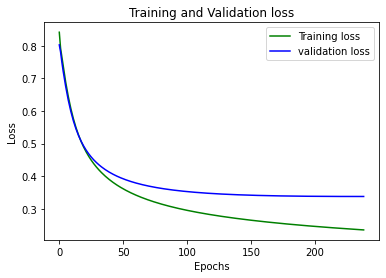

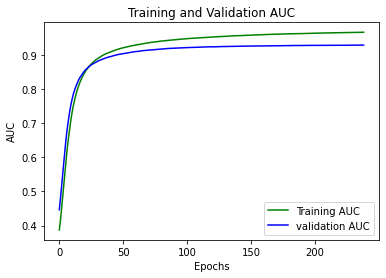

In [12]:
plot_loss_graph(tr_loss,val_loss)
plot_auc_graph(tr_auc,val_auc) 



We got a loss of ~0.33 on validation set when auc on validation set is ~0.92. we stopped the training when the validation loss improvment is too small over 5 consecutive epoches 

**Adding Hidden layers to classifyer**
Now we want to check if adding more hidden layers to the classifyer will improve the results

  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 6.80e-01, Val loss: 6.63e-01
Best val loss is: 6.63e-01
Train loss: 6.55e-01, Val loss: 6.43e-01
Best val loss is: 6.43e-01
Train loss: 6.34e-01, Val loss: 6.21e-01
Best val loss is: 6.21e-01
Train loss: 6.13e-01, Val loss: 6.00e-01
Best val loss is: 6.00e-01
Train loss: 5.92e-01, Val loss: 5.79e-01
Best val loss is: 5.79e-01
Train loss: 5.71e-01, Val loss: 5.58e-01
Best val loss is: 5.58e-01
Train loss: 5.50e-01, Val loss: 5.38e-01
Best val loss is: 5.38e-01


100%|██████████| 11/11 [00:00<00:00, 377.77it/s]

Train loss: 5.29e-01, Val loss: 5.19e-01
Best val loss is: 5.19e-01
Train loss: 5.10e-01, Val loss: 5.01e-01
Best val loss is: 5.01e-01
Train loss: 4.91e-01, Val loss: 4.85e-01
Best val loss is: 4.85e-01
Train loss: 4.74e-01, Val loss: 4.70e-01
Best val loss is: 4.70e-01
Train loss: 4.58e-01, Val loss: 4.57e-01
Best val loss is: 4.57e-01
Train loss: 4.44e-01, Val loss: 4.44e-01
Best val loss is: 4.44e-01



100%|██████████| 11/11 [00:00<00:00, 371.55it/s]

Train loss: 4.30e-01, Val loss: 4.34e-01
Best val loss is: 4.34e-01
Train loss: 4.18e-01, Val loss: 4.24e-01
Best val loss is: 4.24e-01
Train loss: 4.07e-01, Val loss: 4.16e-01
Best val loss is: 4.16e-01
Train loss: 3.97e-01, Val loss: 4.08e-01
Best val loss is: 4.08e-01
Train loss: 3.88e-01, Val loss: 4.01e-01
Best val loss is: 4.01e-01
Train loss: 3.79e-01, Val loss: 3.95e-01
Best val loss is: 3.95e-01
Train loss: 3.71e-01, Val loss: 3.90e-01
Best val loss is: 3.90e-01



100%|██████████| 11/11 [00:00<00:00, 409.97it/s]

Train loss: 3.64e-01, Val loss: 3.85e-01
Best val loss is: 3.85e-01
Train loss: 3.57e-01, Val loss: 3.81e-01
Best val loss is: 3.81e-01
Train loss: 3.51e-01, Val loss: 3.77e-01
Best val loss is: 3.77e-01
Train loss: 3.45e-01, Val loss: 3.73e-01
Best val loss is: 3.73e-01
Train loss: 3.39e-01, Val loss: 3.70e-01
Best val loss is: 3.70e-01
Train loss: 3.34e-01, Val loss: 3.67e-01
Best val loss is: 3.67e-01
Train loss: 3.29e-01, Val loss: 3.64e-01
Best val loss is: 3.64e-01



100%|██████████| 11/11 [00:00<00:00, 421.13it/s]

Train loss: 3.24e-01, Val loss: 3.62e-01
Best val loss is: 3.62e-01
Train loss: 3.20e-01, Val loss: 3.60e-01
Best val loss is: 3.60e-01
Train loss: 3.16e-01, Val loss: 3.58e-01
Best val loss is: 3.58e-01
Train loss: 3.12e-01, Val loss: 3.56e-01
Best val loss is: 3.56e-01
Train loss: 3.08e-01, Val loss: 3.54e-01
Best val loss is: 3.54e-01
Train loss: 3.05e-01, Val loss: 3.53e-01
Best val loss is: 3.53e-01



100%|██████████| 11/11 [00:00<00:00, 388.10it/s]


Train loss: 3.02e-01, Val loss: 3.51e-01
Best val loss is: 3.51e-01
Train loss: 2.98e-01, Val loss: 3.50e-01
Best val loss is: 3.50e-01
Train loss: 2.95e-01, Val loss: 3.49e-01
Best val loss is: 3.49e-01
Train loss: 2.92e-01, Val loss: 3.48e-01
Best val loss is: 3.48e-01
Train loss: 2.90e-01, Val loss: 3.47e-01
Best val loss is: 3.47e-01
Train loss: 2.87e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01
Train loss: 2.84e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.82e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01
Train loss: 2.79e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.77e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 2.75e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.73e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01
Train loss: 2.71e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.69e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.67e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.65e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.63e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.61e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.60e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01


100%|██████████| 11/11 [00:00<00:00, 394.59it/s]


Train loss: 2.58e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.56e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.55e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 2.53e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Stopped training after 56/5000 epochs.
The loss is 6.97e-01 before training and 3.42e-01 after training.
The training and validation losses are 
	[0.6798959350585938, 0.6553937530517578, 0.6338084411621093, 0.6128209686279297, 0.5916514587402344, 0.5705092239379883, 0.5495751953125, 0.5292240905761719, 0.5097362136840821, 0.49133880615234377, 0.4741904830932617, 0.45833492279052734, 0.4437701416015625, 0.430436897277832, 0.41824935913085937, 0.4071086120605469, 0.39691062927246096, 0.3875566482543945, 0.378953742980957, 0.3710190963745117, 0.3636788558959961, 0.35686851501464845, 0.35053142547607424, 0.34461849212646484, 0.33908695220947266, 0.333899040222168, 0.3290222930908203, 0.3244278335571289, 0.32009029388427734

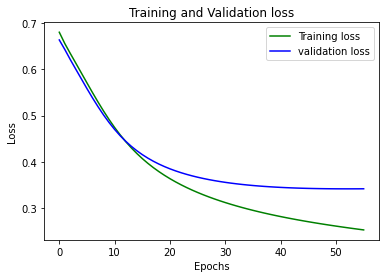

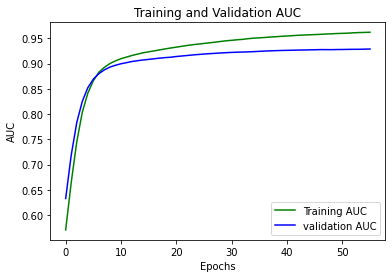

In [13]:
classifyer_with_3_layers = nn.Sequential(
    nn.Linear(512, 20), nn.Linear(20, 10), nn.Linear(10, 2))
net_with_3_layers_in_head = MyResNet(classifyer_with_3_layers, 18)
tr_loss_3_layers, val_loss_3_layers, test_loss_3_layers, tr_auc_3_layers, val_auc_3_layers, untrained_test_loss_3_layers, untrained_test_auc_3_layers = training_loop(
    args,
    net_with_3_layers_in_head,
    X_extracted_features_train,
    y_extracted_features_train,
    X_extracted_features_test,
    y_extracted_features_test,
    val_dataloader=None,
    criterion_func=nn.CrossEntropyLoss
)
plot_loss_graph(tr_loss_3_layers, val_loss_3_layers)
plot_auc_graph(tr_auc_3_layers, val_auc_3_layers)

As we can see the results are pretty similar to the logisitic regression. we also got val loss around ~0.33. In most cases even a little bit bigger than logisitic regression. 1 layer is good enough to generlize the extracted features data.

**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [14]:
#already done on definiton of MyResnet using cases in MyResnet class

# Comparing  ResNet18 with ResNet34:

#### Download the ResNet34 Network from torchvision.models. Then, repeat the steps described above in order to compare between these ResNet18 and ResNet34. Explain your findings and results!

In [15]:
# logistic regression with resnet34 and pytorch
classifyer34 = nn.Sequential(nn.Linear(512, 2))
net34 = MyResNet(classifyer34, 34)
# in case we already extracted the features using resnet34, skip the extraction process(for development)
if(RESNET34_EXTRACTED_DATA_EXIST == False):

    X_extracted_features_train34, y_extracted_features_train34 = net34.extract_features_from_dataloader(
        tr_dataloader)
    X_extracted_features_test34, y_extracted_features_test34 = net34.extract_features_from_dataloader(
        val_dataloader)
    print(X_extracted_features_train34.shape)
    print(X_extracted_features_test34.shape)
    torch.save(X_extracted_features_train,
                args.X_train_extracted_from_resnet34_file_name)
    torch.save(y_extracted_features_train,
                args.y_train_extracted_from_resnet34_file_name)
    torch.save(X_extracted_features_test,
                args.X_test_extracted_from_resnet34_file_name)
    torch.save(y_extracted_features_test,
                args.y_test_extracted_from_resnet34_file_name)
else:
    # load the files
    X_extracted_features_train34 = torch.load(
        args.X_train_extracted_from_resnet34_file_name)
    y_extracted_features_train34 = torch.load(
        args.y_train_extracted_from_resnet34_file_name)
    X_extracted_features_test34 = torch.load(
        args.X_test_extracted_from_resnet34_file_name)
    y_extracted_features_test34 = torch.load(
        args.y_test_extracted_from_resnet34_file_name)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



torch.Size([1600, 512])
torch.Size([500, 512])


# Logistic Regression with scikit-learn library:

In [16]:
# logistic regression with sklearn over resnet34 extracted data

logisticRegr34 = LogisticRegression(penalty='l2',solver='lbfgs',tol=1e-3, max_iter=1000)
clf34 = logisticRegr34.fit(X_extracted_features_train34,
                        y_extracted_features_train34)
pred_probs_train34 = clf34.predict_proba(X_extracted_features_train34)[:,1] # prediction on training set
pred_probs_test34 = clf34.predict_proba(X_extracted_features_test34)[:,1]  #prediction on test set


# train accuracy and auc
accuracy_train_lr34 = clf34.score(
    X_extracted_features_train34, y_extracted_features_train34)
auc_train_lr34 = roc_auc_score(y_extracted_features_train34.numpy(),pred_probs_train34)
# test accuracy and auc
accuracy_test_lr34 = clf34.score(
    X_extracted_features_test34, y_extracted_features_test34)
auc_test_lr34 = roc_auc_score(y_extracted_features_test34.numpy(),pred_probs_test34)

print("train results:")
print('accuracy:', accuracy_train_lr34)
print('auc', auc_train_lr34)
print("test results:")
print('accuracy:', accuracy_test_lr34)
print('auc', auc_test_lr34)
print()


train results:
accuracy: 0.995
auc 0.999821875
test results:
accuracy: 0.828
auc 0.9155840000000001



As we can see , accuracy and auc are very similar to resnet18.
the auc is around ~0.92 and accuracy is around ~0.82.
Hence we can conclude that the resnet18 extracted the features good enough so resnet34 hasn't any added value.

# Logistic Regression with pytorch for ResNet34:

#### Define the model:

In [17]:
#Define above in MyResNet class
net34


MyResNet(
  (features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

#### Training and validation:

In [18]:
tr_loss34, val_loss34, test_loss34, tr_auc34, val_auc34, untrained_test_loss34, untrained_test_auc34 = training_loop(
    args,
    net34,
    X_extracted_features_train34,
    y_extracted_features_train34,
    X_extracted_features_test34,
    y_extracted_features_test34,
    val_dataloader=None,
    criterion_func=nn.CrossEntropyLoss
)

  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 7.07e-01, Val loss: 7.07e-01
Best val loss is: 7.07e-01
Train loss: 6.71e-01, Val loss: 6.72e-01
Best val loss is: 6.72e-01
Train loss: 6.39e-01, Val loss: 6.40e-01
Best val loss is: 6.40e-01
Train loss: 6.10e-01, Val loss: 6.13e-01
Best val loss is: 6.13e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 5.84e-01, Val loss: 5.87e-01
Best val loss is: 5.87e-01
Train loss: 5.61e-01, Val loss: 5.65e-01
Best val loss is: 5.65e-01
Train loss: 5.40e-01, Val loss: 5.45e-01
Best val loss is: 5.45e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 5.21e-01, Val loss: 5.27e-01
Best val loss is: 5.27e-01
Train loss: 5.05e-01, Val loss: 5.12e-01
Best val loss is: 5.12e-01
Train loss: 4.90e-01, Val loss: 4.97e-01
Best val loss is: 4.97e-01
Train loss: 4.76e-01, Val loss: 4.84e-01
Best val loss is: 4.84e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 4.64e-01, Val loss: 4.73e-01
Best val loss is: 4.73e-01
Train loss: 4.52e-01, Val loss: 4.62e-01
Best val loss is: 4.62e-01
Train loss: 4.42e-01, Val loss: 4.53e-01
Best val loss is: 4.53e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 4.33e-01, Val loss: 4.44e-01
Best val loss is: 4.44e-01
Train loss: 4.24e-01, Val loss: 4.36e-01
Best val loss is: 4.36e-01
Train loss: 4.16e-01, Val loss: 4.29e-01
Best val loss is: 4.29e-01
Train loss: 4.08e-01, Val loss: 4.22e-01
Best val loss is: 4.22e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 4.01e-01, Val loss: 4.16e-01
Best val loss is: 4.16e-01
Train loss: 3.95e-01, Val loss: 4.10e-01
Best val loss is: 4.10e-01
Train loss: 3.89e-01, Val loss: 4.05e-01
Best val loss is: 4.05e-01


100%|██████████| 11/11 [00:00<00:00, 447.96it/s]


Train loss: 3.83e-01, Val loss: 4.00e-01
Best val loss is: 4.00e-01
Train loss: 3.78e-01, Val loss: 3.96e-01
Best val loss is: 3.96e-01
Train loss: 3.73e-01, Val loss: 3.91e-01
Best val loss is: 3.91e-01
Train loss: 3.68e-01, Val loss: 3.87e-01
Best val loss is: 3.87e-01


100%|██████████| 11/11 [00:00<00:00, 425.98it/s]

Train loss: 3.64e-01, Val loss: 3.84e-01
Best val loss is: 3.84e-01
Train loss: 3.60e-01, Val loss: 3.80e-01
Best val loss is: 3.80e-01



  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.56e-01, Val loss: 3.77e-01
Best val loss is: 3.77e-01
Train loss: 3.52e-01, Val loss: 3.74e-01
Best val loss is: 3.74e-01
Train loss: 3.48e-01, Val loss: 3.71e-01
Best val loss is: 3.71e-01
Train loss: 3.45e-01, Val loss: 3.69e-01
Best val loss is: 3.69e-01
Train loss: 3.42e-01, Val loss: 3.66e-01
Best val loss is: 3.66e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.38e-01, Val loss: 3.64e-01
Best val loss is: 3.64e-01
Train loss: 3.35e-01, Val loss: 3.62e-01
Best val loss is: 3.62e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.33e-01, Val loss: 3.59e-01
Best val loss is: 3.59e-01
Train loss: 3.30e-01, Val loss: 3.58e-01
Best val loss is: 3.58e-01
Train loss: 3.27e-01, Val loss: 3.56e-01
Best val loss is: 3.56e-01
Train loss: 3.25e-01, Val loss: 3.54e-01
Best val loss is: 3.54e-01
Train loss: 3.22e-01, Val loss: 3.52e-01
Best val loss is: 3.52e-01


100%|██████████| 11/11 [00:00<00:00, 431.14it/s]

Train loss: 3.20e-01, Val loss: 3.51e-01
Best val loss is: 3.51e-01
Train loss: 3.18e-01, Val loss: 3.49e-01
Best val loss is: 3.49e-01



  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.16e-01, Val loss: 3.48e-01
Best val loss is: 3.48e-01
Train loss: 3.13e-01, Val loss: 3.46e-01
Best val loss is: 3.46e-01
Train loss: 3.11e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01
Train loss: 3.09e-01, Val loss: 3.44e-01
Best val loss is: 3.44e-01
Train loss: 3.08e-01, Val loss: 3.43e-01
Best val loss is: 3.43e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.06e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 3.04e-01, Val loss: 3.41e-01
Best val loss is: 3.41e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.02e-01, Val loss: 3.40e-01
Best val loss is: 3.40e-01
Train loss: 3.01e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01
Train loss: 2.99e-01, Val loss: 3.38e-01
Best val loss is: 3.38e-01
Train loss: 2.97e-01, Val loss: 3.37e-01
Best val loss is: 3.37e-01
Train loss: 2.96e-01, Val loss: 3.36e-01
Best val loss is: 3.36e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.94e-01, Val loss: 3.35e-01
Best val loss is: 3.35e-01
Train loss: 2.93e-01, Val loss: 3.34e-01
Best val loss is: 3.34e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.91e-01, Val loss: 3.34e-01
Best val loss is: 3.34e-01
Train loss: 2.90e-01, Val loss: 3.33e-01
Best val loss is: 3.33e-01
Train loss: 2.89e-01, Val loss: 3.32e-01
Best val loss is: 3.32e-01
Train loss: 2.87e-01, Val loss: 3.32e-01
Best val loss is: 3.32e-01
Train loss: 2.86e-01, Val loss: 3.31e-01
Best val loss is: 3.31e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.85e-01, Val loss: 3.31e-01
Best val loss is: 3.31e-01
Train loss: 2.84e-01, Val loss: 3.30e-01
Best val loss is: 3.30e-01


100%|██████████| 11/11 [00:00<00:00, 468.35it/s]

Train loss: 2.83e-01, Val loss: 3.30e-01
Best val loss is: 3.30e-01
Train loss: 2.81e-01, Val loss: 3.29e-01
Best val loss is: 3.29e-01
Train loss: 2.80e-01, Val loss: 3.29e-01
Best val loss is: 3.29e-01
Train loss: 2.79e-01, Val loss: 3.28e-01
Best val loss is: 3.28e-01
Train loss: 2.78e-01, Val loss: 3.28e-01
Best val loss is: 3.28e-01



100%|██████████| 11/11 [00:00<00:00, 496.72it/s]

Train loss: 2.77e-01, Val loss: 3.27e-01
Best val loss is: 3.27e-01
Train loss: 2.76e-01, Val loss: 3.27e-01
Best val loss is: 3.27e-01
Train loss: 2.75e-01, Val loss: 3.26e-01
Best val loss is: 3.26e-01



100%|██████████| 11/11 [00:00<00:00, 478.74it/s]

Train loss: 2.74e-01, Val loss: 3.26e-01
Best val loss is: 3.26e-01
Train loss: 2.73e-01, Val loss: 3.26e-01
Best val loss is: 3.26e-01
Train loss: 2.72e-01, Val loss: 3.25e-01
Best val loss is: 3.25e-01
Train loss: 2.71e-01, Val loss: 3.25e-01
Best val loss is: 3.25e-01



  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.70e-01, Val loss: 3.25e-01
Best val loss is: 3.25e-01
Train loss: 2.69e-01, Val loss: 3.24e-01
Best val loss is: 3.24e-01
Train loss: 2.68e-01, Val loss: 3.24e-01
Best val loss is: 3.24e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.67e-01, Val loss: 3.24e-01
Best val loss is: 3.24e-01
Train loss: 2.67e-01, Val loss: 3.24e-01
Best val loss is: 3.24e-01
Train loss: 2.66e-01, Val loss: 3.23e-01
Best val loss is: 3.23e-01
Train loss: 2.65e-01, Val loss: 3.23e-01
Best val loss is: 3.23e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.64e-01, Val loss: 3.23e-01
Best val loss is: 3.23e-01
Train loss: 2.63e-01, Val loss: 3.23e-01
Best val loss is: 3.23e-01
Train loss: 2.63e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.62e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.61e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.60e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.59e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.59e-01, Val loss: 3.21e-01
Best val loss is: 3.21e-01
Train loss: 2.58e-01, Val loss: 3.21e-01
Best val loss is: 3.21e-01
Train loss: 2.57e-01, Val loss: 3.21e-01
Best val loss is: 3.21e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.57e-01, Val loss: 3.21e-01
Best val loss is: 3.21e-01
Train loss: 2.56e-01, Val loss: 3.21e-01
Best val loss is: 3.21e-01
Train loss: 2.55e-01, Val loss: 3.21e-01
Best val loss is: 3.21e-01
Train loss: 2.55e-01, Val loss: 3.21e-01
Best val loss is: 3.21e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.54e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.53e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.53e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.52e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01


100%|██████████| 11/11 [00:00<00:00, 486.42it/s]

Train loss: 2.51e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.51e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.50e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.50e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01



100%|██████████| 11/11 [00:00<00:00, 517.00it/s]


Train loss: 2.49e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.48e-01, Val loss: 3.20e-01
Best val loss is: 3.20e-01
Train loss: 2.48e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.47e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.47e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.46e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.46e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.45e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.45e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.44e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.44e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.43e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.42e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.42e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.41e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.41e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.41e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.40e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.40e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.39e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.39e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.38e-01, Val loss: 3.19e-01
Best val loss is: 3.19e-01
Train loss: 2.38e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.37e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.37e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.36e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.36e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.35e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.35e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.35e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.34e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.34e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.33e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.33e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.33e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.32e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.32e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.31e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.31e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.31e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Train loss: 2.30e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01


100%|██████████| 11/11 [00:00<00:00, 437.70it/s]

Train loss: 2.30e-01, Val loss: 3.18e-01
Best val loss is: 3.18e-01
Stopped training after 145/5000 epochs.
The loss is 7.45e-01 before training and 3.18e-01 after training.
The training and validation losses are 
	[0.7069248962402344, 0.6710040283203125, 0.6389613342285156, 0.6099291610717773, 0.5839464950561524, 0.5607358551025391, 0.5399740982055664, 0.5213884735107421, 0.504694938659668, 0.4896467971801758, 0.47603443145751956, 0.4636730194091797, 0.45240566253662107, 0.4420987319946289, 0.43263710021972657, 0.4239225387573242, 0.4158707427978516, 0.40840873718261717, 0.4014735794067383, 0.39501075744628905, 0.38897266387939455, 0.3833177947998047, 0.3780097579956055, 0.37301631927490236, 0.36830959320068357, 0.36386421203613284, 0.3596581268310547, 0.35567138671875, 0.35188629150390627, 0.3482871246337891, 0.3448595428466797, 0.3415906524658203, 0.33846900939941404, 0.3354840087890625, 0.33262622833251954, 0.3298869323730469, 0.32725837707519534, 0.3247332382202148, 0.322305068969

#### Visualizing the plots:

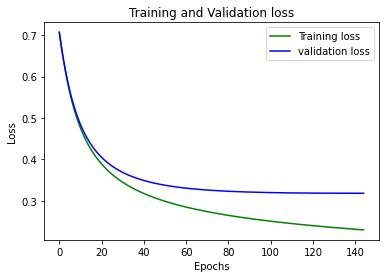

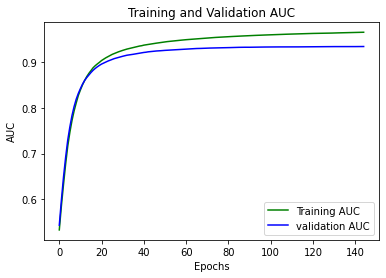

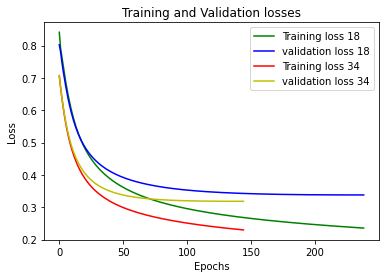

In [19]:
plot_loss_graph(tr_loss34, val_loss34)
plot_auc_graph(tr_auc34, val_auc34)

def plot_loss_graph_for2_models(train_loss_list, validation_loss_list,train_loss_list34, validation_loss_list34,model1_name,model2_name):
    plt.plot(train_loss_list, 'g', label='Training loss '+model1_name)
    plt.plot(validation_loss_list, 'b', label='validation loss '+model1_name)
    plt.plot(train_loss_list34, 'r', label='Training loss '+model2_name)
    plt.plot(validation_loss_list34, 'y', label='validation loss '+model2_name)
    plt.title('Training and Validation losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_graph_for2_models(tr_loss, val_loss,tr_loss34, val_loss34,"18","34")



In the third graph we can see that resnet34 is little better( ~ 0.318) than resnet18 and converged faster(blue and yellow lines)

**Adding Hidden layers to classifyer**
Now we want to check if adding more hidden layers to the classifyer will improve the results

  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 7.40e-01, Val loss: 7.18e-01
Best val loss is: 7.18e-01
Train loss: 7.03e-01, Val loss: 6.85e-01
Best val loss is: 6.85e-01
Train loss: 6.71e-01, Val loss: 6.54e-01
Best val loss is: 6.54e-01
Train loss: 6.41e-01, Val loss: 6.26e-01
Best val loss is: 6.26e-01
Train loss: 6.12e-01, Val loss: 5.98e-01
Best val loss is: 5.98e-01
Train loss: 5.85e-01, Val loss: 5.71e-01
Best val loss is: 5.71e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 5.58e-01, Val loss: 5.45e-01
Best val loss is: 5.45e-01
Train loss: 5.32e-01, Val loss: 5.21e-01
Best val loss is: 5.21e-01
Train loss: 5.07e-01, Val loss: 4.98e-01
Best val loss is: 4.98e-01
Train loss: 4.84e-01, Val loss: 4.77e-01
Best val loss is: 4.77e-01
Train loss: 4.62e-01, Val loss: 4.58e-01
Best val loss is: 4.58e-01
Train loss: 4.42e-01, Val loss: 4.41e-01
Best val loss is: 4.41e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 4.24e-01, Val loss: 4.25e-01
Best val loss is: 4.25e-01
Train loss: 4.08e-01, Val loss: 4.12e-01
Best val loss is: 4.12e-01
Train loss: 3.93e-01, Val loss: 4.00e-01
Best val loss is: 4.00e-01
Train loss: 3.80e-01, Val loss: 3.89e-01
Best val loss is: 3.89e-01
Train loss: 3.68e-01, Val loss: 3.80e-01
Best val loss is: 3.80e-01
Train loss: 3.57e-01, Val loss: 3.72e-01
Best val loss is: 3.72e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.48e-01, Val loss: 3.65e-01
Best val loss is: 3.65e-01
Train loss: 3.39e-01, Val loss: 3.59e-01
Best val loss is: 3.59e-01
Train loss: 3.31e-01, Val loss: 3.54e-01
Best val loss is: 3.54e-01
Train loss: 3.24e-01, Val loss: 3.49e-01
Best val loss is: 3.49e-01
Train loss: 3.17e-01, Val loss: 3.45e-01
Best val loss is: 3.45e-01
Train loss: 3.11e-01, Val loss: 3.42e-01
Best val loss is: 3.42e-01
Train loss: 3.06e-01, Val loss: 3.39e-01
Best val loss is: 3.39e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 3.00e-01, Val loss: 3.36e-01
Best val loss is: 3.36e-01
Train loss: 2.96e-01, Val loss: 3.34e-01
Best val loss is: 3.34e-01
Train loss: 2.91e-01, Val loss: 3.32e-01
Best val loss is: 3.32e-01
Train loss: 2.87e-01, Val loss: 3.30e-01
Best val loss is: 3.30e-01
Train loss: 2.83e-01, Val loss: 3.29e-01
Best val loss is: 3.29e-01
Train loss: 2.80e-01, Val loss: 3.27e-01
Best val loss is: 3.27e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.76e-01, Val loss: 3.26e-01
Best val loss is: 3.26e-01
Train loss: 2.73e-01, Val loss: 3.25e-01
Best val loss is: 3.25e-01
Train loss: 2.70e-01, Val loss: 3.24e-01
Best val loss is: 3.24e-01
Train loss: 2.67e-01, Val loss: 3.24e-01
Best val loss is: 3.24e-01
Train loss: 2.64e-01, Val loss: 3.23e-01
Best val loss is: 3.23e-01
Train loss: 2.62e-01, Val loss: 3.23e-01
Best val loss is: 3.23e-01


  0%|          | 0/11 [00:00<?, ?it/s]

Train loss: 2.59e-01, Val loss: 3.23e-01
Best val loss is: 3.23e-01
Train loss: 2.57e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.54e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.52e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.50e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.48e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01


100%|██████████| 11/11 [00:00<00:00, 369.75it/s]


Train loss: 2.46e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.44e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Train loss: 2.42e-01, Val loss: 3.22e-01
Best val loss is: 3.22e-01
Stopped training after 46/5000 epochs.
The loss is 7.63e-01 before training and 3.22e-01 after training.
The training and validation losses are 
	[0.74009765625, 0.7033081817626953, 0.6709416961669922, 0.6411076354980468, 0.6123169708251953, 0.5845088195800782, 0.5575684356689453, 0.5316026687622071, 0.5068881988525391, 0.4836553955078125, 0.46208412170410157, 0.44227012634277346, 0.42422134399414063, 0.4078831100463867, 0.3931513214111328, 0.3798964309692383, 0.3679764938354492, 0.35724925994873047, 0.34757869720458984, 0.3388389205932617, 0.33091629028320313, 0.32370986938476565, 0.31713075637817384, 0.3111016082763672, 0.30555507659912107, 0.30043294906616214, 0.2956849479675293, 0.2912677574157715, 0.28714372634887697, 0.28328054428100585, 0.2796501731872559, 0.2762281799316406, 0.

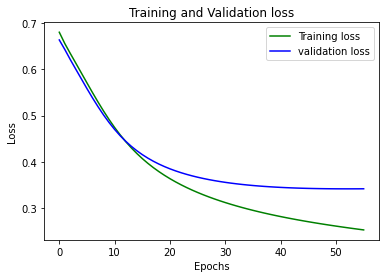

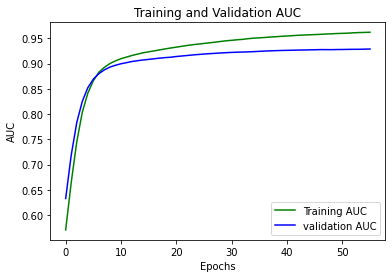

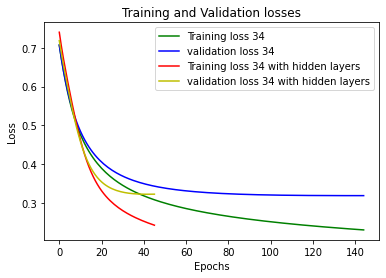

In [20]:
classifyer_with_3_layers = nn.Sequential(
    nn.Linear(512, 20), nn.Linear(20, 10), nn.Linear(10, 2))
net34_with_3_layers_in_head = MyResNet(classifyer_with_3_layers, 18)
tr_loss_3_layers34, val_loss_3_layers34, test_loss_3_layers34, tr_auc_3_layers34, val_auc_3_layers34, untrained_test_loss_3_layers34, untrained_test_auc_3_layers34 = training_loop(
    args,
    net34_with_3_layers_in_head,
    X_extracted_features_train34,
    y_extracted_features_train34,
    X_extracted_features_test34,
    y_extracted_features_test34,
    val_dataloader=None,
    criterion_func=nn.CrossEntropyLoss
)
plot_loss_graph(tr_loss_3_layers, val_loss_3_layers)
plot_auc_graph(tr_auc_3_layers, val_auc_3_layers)
plot_loss_graph_for2_models(tr_loss34, val_loss34,tr_loss_3_layers34, val_loss_3_layers34,"34","34 with hidden layers")


As we can see again the results are pretty similar to the 1 layer in classifyer. Adding more layers to the classifyer dont have any affect on the validation loss

**Here you should merge the feature extractor network layers with the PyTorch logistic regression classifier.**

In [21]:
### Already done on definition of MyResnet class using cases


# Part 2- Fine-tuning

In the feature extraction experiment above you were training the classifier on the top of the pre-trained model. 
In this paert, you need to train (or "fine-tune") the original pre-trained Resnet18 model (or part of them) in an attempts to improve your results. You can determine the number of convolution layers you intend to re-train in order to avoid overfitting and hopefully achive better generalization. Note that the fine-tuning should only be attempted after you have trained the top-level classifier with a pre-trained model.

1. Plot Loss and Accuracy v.s Epoch for train and validation sets:

#### Define the model (use the merged feature extractor with the PyTorch logistic regression classifier)

In [26]:
print('finetuning')
net_ft = net #trained net from resnet18 with classifyer nn.linear(512,2)+softmax as head
for param in net_ft.features.parameters():
    param.requires_grad = True
args.lr = args.lr_finetune # choose small learning rate for finetuning
args.early_stopping_min_improvement = args.early_stopping_min_improvement_ft
args.early_stopping_num_epochs = args.early_stopping_num_epochs_ft

finetuning


#### Training and validation:

In [23]:
tr_loss_ft, val_loss_ft, test_loss_ft, tr_auc_ft, val_auc_ft, untrained_test_loss_ft, untrained_test_auc_ft,tr_accuracy,val_accuracy = training_loop_with_dataloaders(
    args,
    net_ft,
    tr_dataloader=tr_dataloader,
    val_dataloader=val_dataloader,
    criterion_func=nn.CrossEntropyLoss,
    fine_tune=True
)

untrained accuracy: 0.844
validtaion_acc: 0.856
Train loss: 2.48e-01, Val loss: 3.26e-01
Best val loss is: 3.26e-01
validtaion_acc: 0.864
Train loss: 1.86e-01, Val loss: 3.16e-01
Best val loss is: 3.16e-01
validtaion_acc: 0.864
Train loss: 1.46e-01, Val loss: 3.16e-01
Best val loss is: 3.16e-01
validtaion_acc: 0.866
Train loss: 1.18e-01, Val loss: 3.23e-01
Best val loss is: 3.16e-01
Stopped training after 4/5000 epochs.
The loss is 3.38e-01 before training and 3.23e-01 after training.
The training and validation losses are 
	[0.24814678192138673, 0.18609451293945312, 0.14582244873046876, 0.11848459243774415, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 

#### Visualizing the plots:

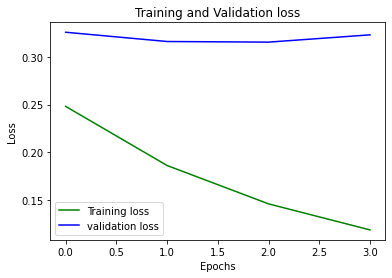

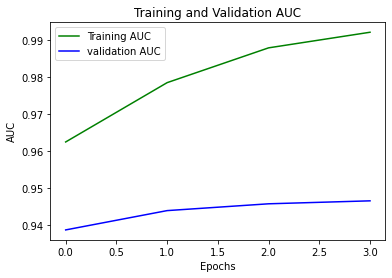

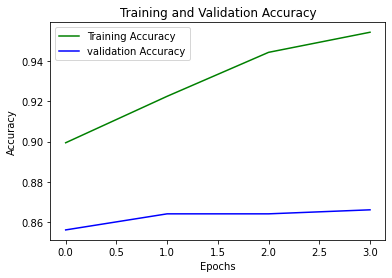

In [24]:
plot_loss_graph(tr_loss_ft, val_loss_ft)
plot_auc_graph(tr_auc_ft, val_auc_ft)
plot_Accuracy_graph(tr_accuracy,val_accuracy)



2. Compare your results between the two approaches. Is there any improvement? Explain your findings...


Type your answer here:


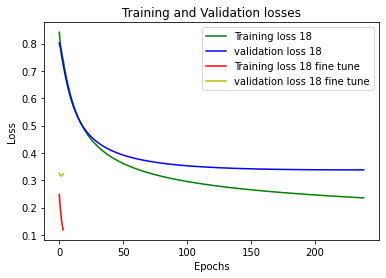

In [25]:
plot_loss_graph_for2_models(tr_loss,val_loss,tr_loss_ft,val_loss_ft,"18","18 fine tune")


We can see that the fine tuning process(yellow line) gives lower loss(~ 0.31) and better accuracy than using only feature extraction(~0.33) -blue line.
Fine tuning method uses the trained net of feature extraction process.
In this process we train the whole net(including resnet!) and not just the classifyer. we used very small learning rate
to tune resnet18 weights so that it will fit more to our mission(dogs and cats) than it's original task(ImageNet classes)
Its make sense that when we take off the constraint(train only the classifyer), the results will be better.